Let's implement the example in Figure 3 in the paper:


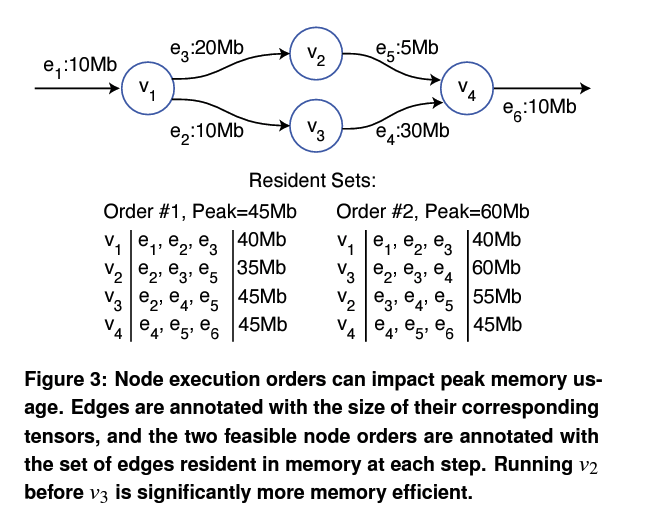

First we implement the "bad" order, Order #2

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import olla

In [33]:
class SimpleModule(torch.nn.Module):
    def __init__(self):
        super(SimpleModule, self).__init__()
        self.v1 = V1()
        self.v3 = V3()
        self.v2 = V2()
        self.v4 = V4()

    def forward(self, e1):
        e3, e2 = self.v1(e1)
        e4 = self.v3(e2)
        e5 = self.v2(e3)
        e6 = self.v4(e4, e5)
        return e6

class V1(torch.nn.Module):
    def forward(self, e1):
        e2 = e1.clone()
        e3 = torch.cat([e1, e1])
        return e3, e2

class V2(torch.nn.Module):
    def forward(self, e3):
        e5 = e3[0::4].clone()
        return e5

class V3(torch.nn.Module):
    def forward(self, e2):
        e4 = torch.cat([e2, e2, e2])
        return e4

class V4(torch.nn.Module):
    def forward(self, e4, e5):
        e6 = torch.cat([e5, e4[::6]])
        return e6


In [34]:
model = None
input = None

# Eager

In [35]:
model = SimpleModule().cuda()

In [36]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

In [37]:
input = torch.rand(10*1024*1024 // 4).cuda()
model(input)

tensor([0.4963, 0.3074, 0.4556,  ..., 0.6341, 0.7861, 0.6962], device='cuda:0')

In [38]:
from pprint import pprint
snapshot = torch.cuda.memory._snapshot()
# pprint(snapshot)
from pickle import dump
dump(snapshot, open('snapshot_eager.pickle', 'wb'))

In [39]:
!python _memory_viz.py trace_plot snapshot_eager.pickle -o snapshot_eager.html

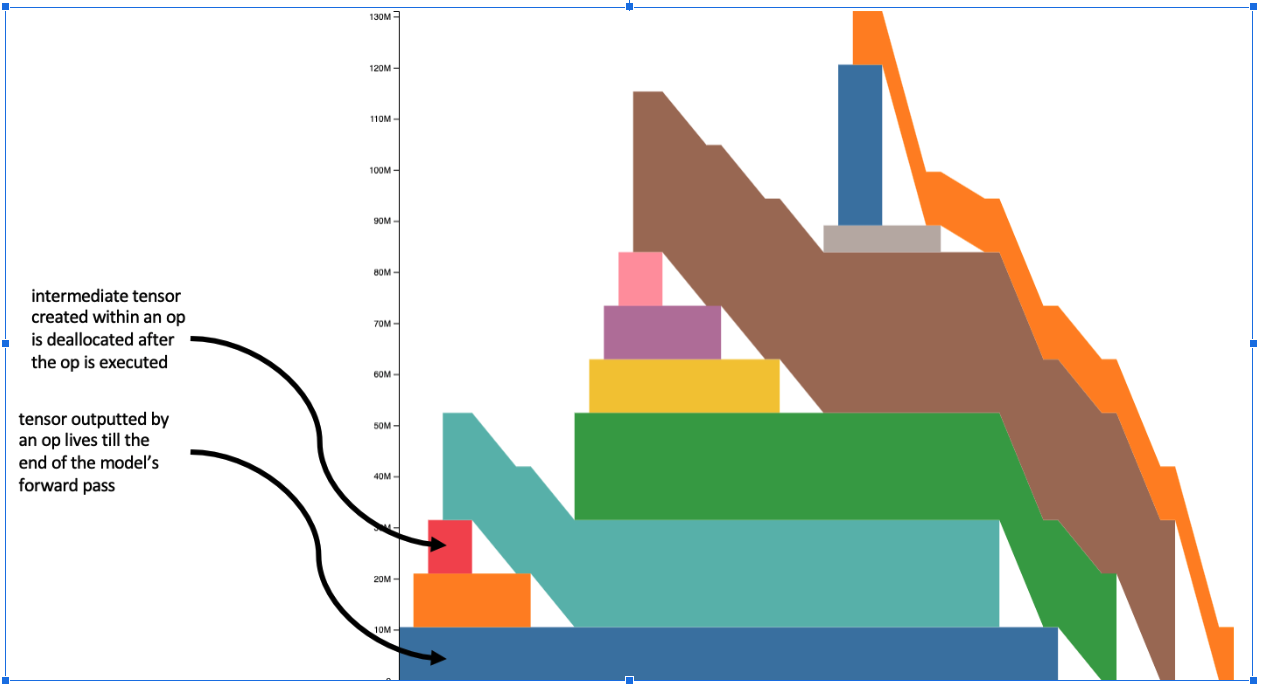


You can view an interactive version of the trace [here](https://www.dropbox.com/s/hmug3fj8l5e9zum/snapshot_eager.html?dl=0).

# Compiled Mode: torch.fx

NOTE: Need to restart the Notebook and run the above cells without the "Eager" section.


TODO: Check with Zachary how to reset memory and stats.

In [9]:
if model:
    del model
    model = None
if input:
    del input
    input = None

model = SimpleModule().cuda()

In [40]:
# custom tracer to treat V1, V2, V3, and V4 as ops and avoid tracing through them
class CustomTracer(torch.fx.Tracer):
    def is_leaf_module(self, m: torch.nn.Module, module_qualified_name: str) -> bool:
        return isinstance(m, V1) or isinstance(m, V2) or isinstance(m, V3) or isinstance(m, V4) 

In [42]:
model = torch.fx.GraphModule(model, CustomTracer().trace(model))
print(model.code)




def forward(self, e1):
    v1 = self.v1(e1);  e1 = None
    getitem = v1[0]
    getitem_1 = v1[1];  v1 = None
    v3 = self.v3(getitem_1);  getitem_1 = None
    v2 = self.v2(getitem);  getitem = None
    v4 = self.v4(v3, v2);  v3 = v2 = None
    return v4
    


In [44]:
model.graph.print_tabular()

opcode         name       target                       args          kwargs
-------------  ---------  ---------------------------  ------------  --------
placeholder    e1         e1                           ()            {}
call_module    v1         v1                           (e1,)         {}
call_function  getitem    <built-in function getitem>  (v1, 0)       {}
call_function  getitem_1  <built-in function getitem>  (v1, 1)       {}
call_module    v3         v3                           (getitem_1,)  {}
call_module    v2         v2                           (getitem,)    {}
call_module    v4         v4                           (v3, v2)      {}
output         output     output                       (v4,)         {}


In [46]:
drawing = torch.fx.passes.graph_drawer.FxGraphDrawer(model, "orig_fx")
with open("orig_fx.dot", "wb") as f:
    f.write(drawing.get_dot_graph().create_dot())
with open("orig_fx.svg", "wb") as f:
    f.write(drawing.get_dot_graph().create_svg())
with open("orig_fx.png", "wb") as f:
    f.write(drawing.get_dot_graph().create_png())

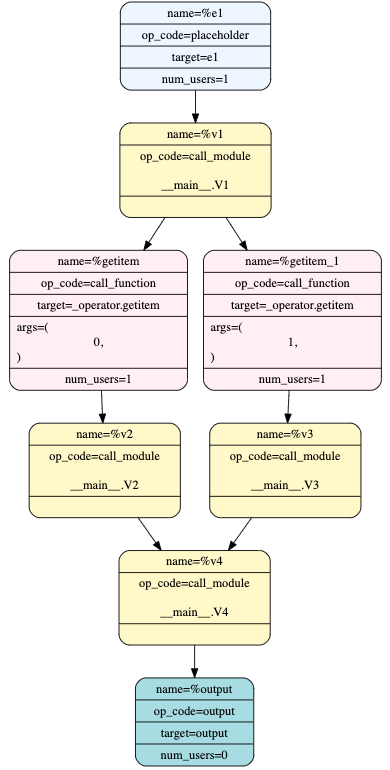

In [13]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

In [14]:
input = torch.rand(10*1024*1024 // 4).cuda()
model(input)

tensor([0.1996, 0.2193, 0.2290,  ..., 0.6276, 0.5618, 0.3442], device='cuda:0')

In [15]:
from pprint import pprint
snapshot = torch.cuda.memory._snapshot()
# pprint(snapshot)
from pickle import dump
dump(snapshot, open('snapshot_fx.pickle', 'wb'))

In [16]:
!python _memory_viz.py trace_plot snapshot_fx.pickle -o snapshot_fx.html

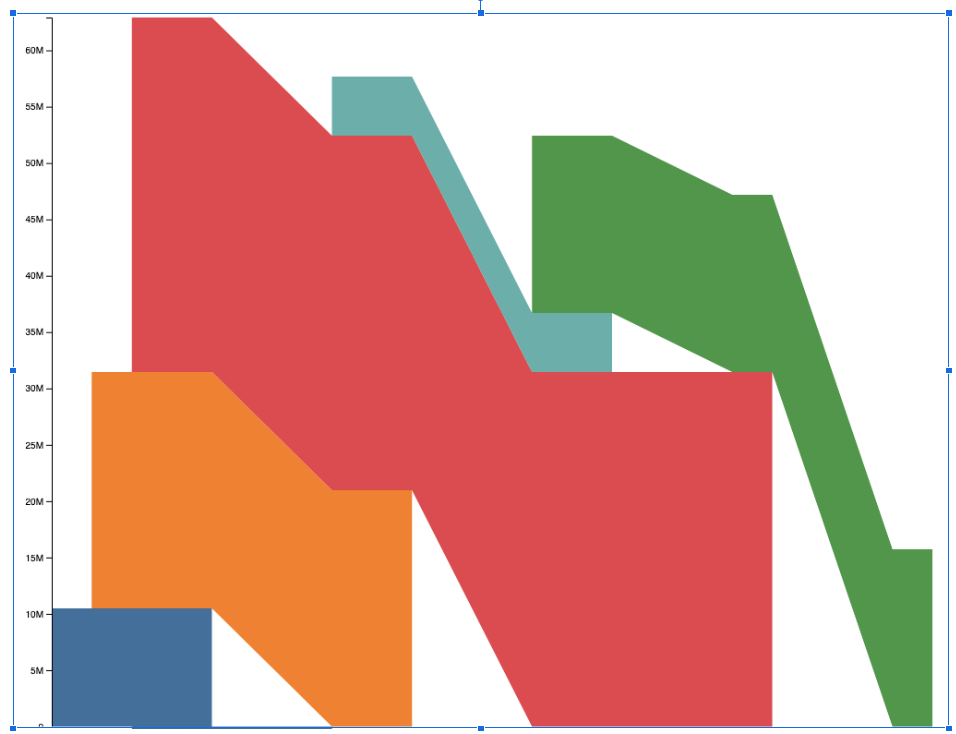

You can view an interactive version of the trace [here](https://www.dropbox.com/s/64j1rg6rqvulgml/snapshot_fx.html?dl=0)

# OLLA

In [4]:
if model:
    del model
    model = None
if input:
    del input
    input = None

model = SimpleModule().cuda()
input = torch.rand(10*1024*1024 // 4).cuda()

In [5]:
# custom tracer to treat V1, V2, V3, and V4 as ops and avoid tracing through them
class CustomTracer(torch.fx.Tracer):
    def is_leaf_module(self, m: torch.nn.Module, module_qualified_name: str) -> bool:
        return isinstance(m, V1) or isinstance(m, V2) or isinstance(m, V3) or isinstance(m, V4) 

In [6]:
importer = olla.torch.torch_graph_importer.TorchGraphImporter()
(
    g,
    pytorch_node_order,
    fx_graph,
    fx_to_df_map,
) = importer.import_via_fx(
    model,
    input,
    mode="eval",
    tracer_class=CustomTracer,
    cleanup=True,
    treat_output_as_fake=False,
    return_node_ordering=True,
    return_fx_graph=True,
)
assert(g.is_valid())
g.canonicalize()
g.constrain_weight_updates()
g.constrain_tensor_generators()
assert(g.is_valid())

node_order = str([node for node in fx_graph.graph.nodes])


MODEL STATS: #RAW NODES=8, #RAW EDGES=7
MODEL STATS: #ACTUAL OPERATORS=8, #ACTUAL TENSORS=7


In [ ]:
del input
input = None

In [7]:
g.dump("orig_graph", format="png")


'orig_graph'

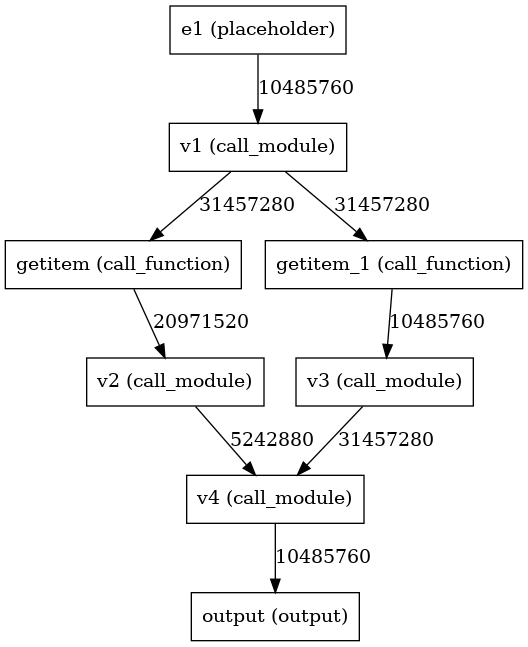

In [8]:
!source ~/.bashrc

In [15]:
s = olla.training_graph_optimizer.Scheduler(g)
summary, schedule, mem_loc = s.ComputeOptimalSchedule(
    allow_swaps=False,
    max_spills=0,
)
# print(f"SCHEDULER = {schedule}")
node_order_optimized = olla.utils.extract_node_ordering(g, schedule)

Set parameter OutputFlag to value 1


In [16]:
fx_opt = olla.torch.fx_optimizer.FXOptimizer(fx_graph, fx_to_df_map)
fx_opt.Reorder(node_order_optimized)
fx_graph_opt = fx_opt.fx_trace

In [20]:
print(fx_graph_opt.code)




def forward(self, e1):
    v1 = self.v1(e1);  e1 = None
    getitem = v1[0]
    getitem_1 = v1[1];  v1 = None
    v2 = self.v2(getitem);  getitem = None
    v3 = self.v3(getitem_1);  getitem_1 = None
    v4 = self.v4(v3, v2);  v3 = v2 = None
    return v4
    


In [19]:
fx_graph_opt.graph.print_tabular()

opcode         name       target                       args          kwargs
-------------  ---------  ---------------------------  ------------  --------
placeholder    e1         e1                           ()            {}
call_module    v1         v1                           (e1,)         {}
call_function  getitem    <built-in function getitem>  (v1, 0)       {}
call_function  getitem_1  <built-in function getitem>  (v1, 1)       {}
call_module    v2         v2                           (getitem,)    {}
call_module    v3         v3                           (getitem_1,)  {}
call_module    v4         v4                           (v3, v2)      {}
output         output     output                       (v4,)         {}


In [17]:
drawing = torch.fx.passes.graph_drawer.FxGraphDrawer(fx_graph_opt, "olla_fx")
with open("olla_fx.svg", "wb") as f:
    f.write(drawing.get_dot_graph().create_svg())
with open("olla_fx.png", "wb") as f:
    f.write(drawing.get_dot_graph().create_png())

In [21]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

In [25]:
with torch.no_grad():
    input = torch.rand(10*1024*1024 // 4).cuda()
    torch.manual_seed(0)
    final_result = fx_graph_opt.forward(
        input,
        #params=dict(model.named_parameters()),
        #buffers=dict(model.named_buffers()),
    )

In [26]:
from pprint import pprint
snapshot = torch.cuda.memory._snapshot()
# pprint(snapshot)
from pickle import dump
dump(snapshot, open('snapshot_olla.pickle', 'wb'))

In [27]:
!python _memory_viz.py trace_plot snapshot_olla.pickle -o snapshot_olla.html

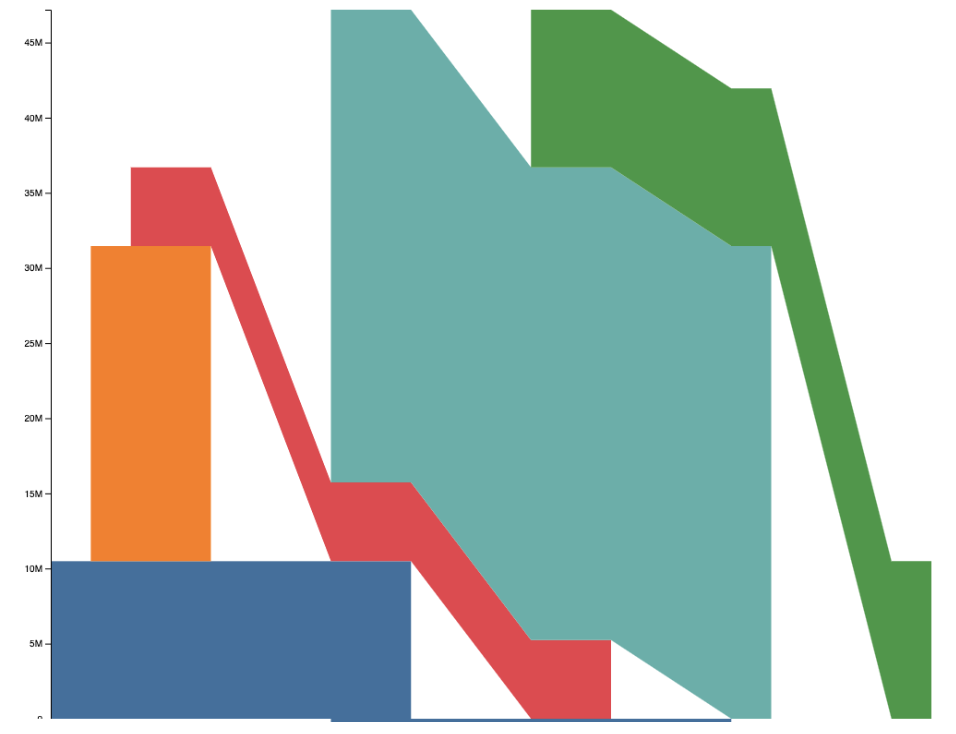


You can view an interactive version of the trace [here](https://www.dropbox.com/s/e12npivpnd8zjxu/snapshot_olla.html?dl=0).

## OLLA API

The code above to optimize the model looks complicated. But we have abstracted all that in a function `olla.optimize(...)`

In [ ]:
if model:
    del model
    model = None
if input:
    del input
    input = None

In [31]:
model.eval()
input = torch.rand(10*1024*1024 // 4).cuda()
model = olla.optimize(model, input)

MODEL STATS: #RAW NODES=8, #RAW EDGES=7
MODEL STATS: #ACTUAL OPERATORS=6, #ACTUAL TENSORS=5
Set parameter OutputFlag to value 1


/private/home/melhoushi/miniconda3/envs/olla_2.0/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(
/private/home/melhoushi/miniconda3/envs/olla_2.0/lib/python3.10/site-packages/torch/fx/node.py:250: UserWarning: Trying to prepend a node to itself. This behavior has no effect on the graph.
  warnings.warn("Trying to prepend a node to itself. This behavior has no effect on the graph.")


In [ ]:
del input
input = None

In [ ]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

In [ ]:
input = torch.rand(10*1024*1024 // 4).cuda()
output = model(input)

In [ ]:
from pprint import pprint
snapshot = torch.cuda.memory._snapshot()
# pprint(snapshot)
from pickle import dump
dump(snapshot, open('snapshot_olla_api.pickle', 'wb'))

In [ ]:
!python _memory_viz.py trace_plot snapshot_olla_api.pickle -o snapshot_olla_api.html